In [1]:
import pandas as pd
import numpy as np
import datetime
import boto3
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, date2num
import seaborn as sns
import scipy.stats as stats
import difflib

In [2]:
#reads in sample of kiva data (10k rows)
loan = pd.read_csv('../data/sample_data.csv')

In [3]:

#converting string representations of time to Datetime objects
loan['posted_datetime'] = pd.to_datetime(loan['POSTED_TIME'])
loan['raised_datetime'] = pd.to_datetime(loan['RAISED_TIME'])

#creates loan_speed column as difference between raised and posted datetimes
loan['loan_speed'] = loan['raised_datetime']-loan['posted_datetime']

#represents time to raising loan in number of days (for matplotlib)
loan['loanspeed_days'] = loan['loan_speed'] / pd.Timedelta(hours=24)

#drops na values
loan.dropna(subset=['raised_datetime'], inplace=True)

#creates loan_year column 
loan['loan_year'] = [loan['raised_datetime'][x].year for x in loan.index]


In [4]:
#Function for counting number of borrowers from number of entries in gender column 
def count_borrowers(lst):
    if type(lst) != float:
        return len(lst.split(','))
    else:
        return 1

loan['borrower_n'] = loan['BORROWER_GENDERS'].apply(count_borrowers)


In [5]:
#reads in csv of purchasing power parity values from world bank
#first four rows are skipped to avoid irrelevant metadata
ppp = pd.read_csv('../data/world_bank_ppp.csv', skiprows=4, index_col='Country Name')




In [6]:
def rel_ppp(country, loan_year):
    for c, y in zip(country, loan_year):
        if y == 2020:
            loan.at[c, '2019']
        elif y <= 2020:
            return ppp.at[c, str(y)]
        else:
            return 0

rel_ppp(loan['COUNTRY_NAME'], loan['loan_year'])

0.580266058444977

In [7]:


#Check for spelling difference between country names in loan data and county names in ppp data

ppp.reset_index(inplace=True)

#set all countries names to lower case 
loan['COUNTRY_NAME'] = [c.lower() for c in loan['COUNTRY_NAME']]
ppp['Country Name'] = [c.lower() for c in ppp['Country Name']]

#returns list of countries that are not matches between the data sets
for c in set(loan['COUNTRY_NAME']):
    match_tup = (c, difflib.get_close_matches(c, ppp['Country Name'], cutoff=1))
    if match_tup[1] == []:
        print(match_tup[0])
        



myanmar (burma)
lao people's democratic republic
congo
the democratic republic of the congo
yemen
palestine
egypt
kyrgyzstan


In [8]:
#Only 8 out of 82 countries are not matches. Most of the remaining difference are due to political
#differences in naming, rather than failure to do a fuzzy match. 



ppp = ppp.rename(index={'west bank and gaza':'palestine', 'congo, rep':'congo', 'myanmar ':'myanmar (burma)',
'yemen, rep.':'yemen', 'lao pdr':'lao people''s democratic republic',
'congo, dem. rep.':'the democratic republic of the congo', 'egypt arab rep.': 'egypt'})

In [9]:
ppp.set_index('Country Name', inplace=True)
ppp.index

Index(['aruba', 'afghanistan', 'angola', 'albania', 'andorra', 'arab world',
       'united arab emirates', 'argentina', 'armenia', 'american samoa',
       ...
       'virgin islands (u.s.)', 'vietnam', 'vanuatu', 'world', 'samoa',
       'kosovo', 'yemen, rep.', 'south africa', 'zambia', 'zimbabwe'],
      dtype='object', name='Country Name', length=264)

In [10]:
#creates list with country name and loan year from loan data   
holder = []
for c,y in zip(loan['COUNTRY_NAME'], loan['loan_year']):
    holder.append([c,y])




In [11]:
for i in range(len(holder)):
    if holder[i][0] not in ppp.index:
        holder[i].append(np.nan)
    elif np.isnan(ppp.loc[holder[i][0], str(holder[i][1])]):
        if (ppp.loc[holder[i][0], str(holder[i][1]-1)]):
            holder[i].append(ppp.loc[holder[i][0], str(holder[i][1]-1)])
        elif (ppp.loc[holder[i][0], str(holder[i][1]-2)]):
            holder[i].append(ppp.loc[holder[i][0], str(holder[i][1]-2)])
        else:    
            holder[i].append(np.nan)
    else:
        holder[i].append(ppp.loc[holder[i][0],str(holder[i][1])])
        



In [14]:
#Creates ppp value in loan datafarme
loan['ppp'] = [holder[c][2] for c in range(len(holder))]



In [15]:

loan['ppp'].dropna(inplace=True)

In [19]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9500 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   Unnamed: 0                       9500 non-null   int64              
 1   LOAN_ID                          9500 non-null   int64              
 2   LOAN_NAME                        9264 non-null   object             
 3   ORIGINAL_LANGUAGE                9284 non-null   object             
 4   DESCRIPTION                      9284 non-null   object             
 5   DESCRIPTION_TRANSLATED           7124 non-null   object             
 6   FUNDED_AMOUNT                    9500 non-null   float64            
 7   LOAN_AMOUNT                      9500 non-null   float64            
 8   STATUS                           9500 non-null   object             
 9   IMAGE_ID                         9284 non-null   float64            
 10  

In [22]:
loan['ppp_val'] = loan['ppp'] * loan['LOAN_AMOUNT']

In [23]:

#gender
loanspeed_m = loan['loanspeed_days'][loan['BORROWER_GENDERS']=='male']
loanspeed_f = loan['loanspeed_days'][loan['BORROWER_GENDERS']=='female']

mx = np.mean(loanspeed_m)
mf = np.mean(loanspeed_f)



Ttest_indResult(statistic=18.702402824218993, pvalue=1.6755581566396565e-76)

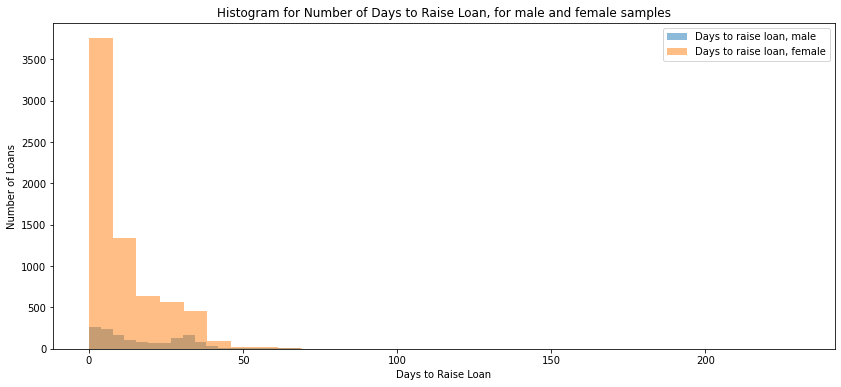

In [37]:
#We can see by plotting the histograms for how long men and women take to raise loans that
#a) the data does not appear to be normally distributed and 
#b) there are many more datapoints for women than for men 

fig, ax = plt.subplots(figsize=(14,6))
ax.hist(loanspeed_m, bins=30, alpha=.5, label='Days to raise loan, male')
ax.hist(loanspeed_f, bins=30, alpha=.5, label='Days to raise loan, female')
ax.legend(loc='upper right')
ax.set_xlabel('Days to Raise Loan')
ax.set_ylabel('Number of Loans')
ax.set_title('Histogram for Number of Days to Raise Loan, for male and female samples')

plt.savefig('../images/gender_histogram.png')


In [33]:
stats.mannwhitneyu(loanspeed_m, loanspeed_f)

MannwhitneyuResult(statistic=3683198.5, pvalue=4.326373415336906e-66)

In [151]:


for x in set(loan['COUNTRY_NAME']):
    print (stats.shapiro(loan['loanspeed_days'][loan['COUNTRY_NAME']==x])[1])
 #   if stats.shapiro(loan['loanspeed_days'][loan['COUNTRY_NAME']==x])[1] < .05:
 #       print("Loans in {country}, are not normally distributed ".format(country=x))
 #   else:
 #       None

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: COUNTRY_NAME, Length: 9500, dtype: bool
2.772965745911904e-10
0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: COUNTRY_NAME, Length: 9500, dtype: bool
6.63980182684723e-14
0        True
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: COUNTRY_NAME, Length: 9500, dtype: bool
7.441859628531944e-12
0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: COUNTRY_NAME, Length: 9500, dtype: bool
0.07887250185012817
0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
999

ValueError: Data must be at least length 3.

,Unnamed: 0,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,...,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,posted_datetime,raised_datetime,loan_speed,loanspeed_days,loan_year,borrower_n,ppp,ppp_val
0,0,822769,Ana Olaya,Spanish,En el cantón 24 De Mayo de la provincia de Ma...,"In the 24 De Mayo canton, Manabí province, kno...",825.0,825.0,funded,1772632.0,...,monthly,field_partner,2014-12-30 23:15:46+00:00,2015-01-26 21:41:32+00:00,26 days 22:25:46,26.934560,2015,1,0.580266,478.719498
1,1,758447,JOVELINE\t,English,Joveline is married and has two children. She ...,Joveline is married and has two children. She ...,525.0,525.0,funded,1677756.0,...,monthly,field_partner,2014-08-22 05:03:19+00:00,2014-09-02 15:48:57+00:00,11 days 10:45:38,11.448356,2014,1,19.067863,10010.628319
2,2,443481,JUAN ANGEL,Spanish,"Juan es un hombre de 54 años, es felizmente ca...","Juan, 54, is happily married. He lives with h...",400.0,400.0,funded,1127992.0,...,monthly,field_partner,2012-06-26 22:25:17+00:00,2012-07-26 03:01:16+00:00,29 days 04:35:59,29.191655,2012,1,1.572296,628.918314
3,3,943914,Delilah,English,Delilah is 45 years old and married with four ...,Delilah is 45 years old and married with four ...,225.0,225.0,funded,1972607.0,...,monthly,field_partner,2015-09-06 00:53:47+00:00,2015-09-14 13:35:36+00:00,8 days 12:41:49,8.529039,2015,1,19.038708,4283.709240
4,4,149321,Hurmatoy,English,K. Hurmatoy is a happy mother of three childre...,NaN,1575.0,1575.0,funded,418838.0,...,monthly,field_partner,2009-11-02 11:37:40+00:00,2009-11-02 21:24:33+00:00,0 days 09:46:53,0.407558,2009,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,537242,Ana,English,Ana is 21 years old and married with one child...,NaN,450.0,450.0,funded,1311558.0,...,monthly,field_partner,2013-03-13 07:39:30+00:00,2013-03-15 23:01:18+00:00,2 days 15:21:48,2.640139,2013,1,1.883895,847.752582
9996,9996,1197482,Liliane,French,Liliane continue a progressé dans son commerce...,Liliane continues to progress in her commerce....,250.0,250.0,funded,2379501.0,...,monthly,field_partner,2016-12-02 05:37:09+00:00,2016-12-04 23:48:22+00:00,2 days 18:11:13,2.757789,2016,1,27.211857,6802.964211
9997,9997,1032489,Ana Liza,English,Ana Liza is a hardworking woman entrepreneur.<...,Ana Liza is a hardworking woman entrepreneur.<...,225.0,225.0,funded,2116650.0,...,monthly,field_partner,2016-03-03 02:44:46+00:00,2016-03-06 18:13:36+00:00,3 days 15:28:50,3.645023,2016,1,18.925903,4258.328247
9998,9998,1488538,José Romel,Spanish,"José, tiene 40 años de edad, estudió hasta sép...",José is 40 years old. He went to school up to ...,600.0,600.0,funded,2796905.0,...,monthly,field_partner,2018-03-14 15:45:10+00:00,2018-04-04 07:21:50+00:00,20 days 15:36:40,20.650463,2018,1,0.508201,304.920734


In [39]:
#sector analysis
for x in set(loan['SECTOR_NAME']):
    if stats.ttest_ind(loan['loanspeed_days'][loan['SECTOR_NAME']==x], loan['loanspeed_days']
                       [loan['loanspeed_days']!=x],
                       alternative='two-sided')[1] < .05:
        
        print("Loans in {sector}, average of {mean} days to raise loan".format(sector=x,
                                                            mean=np.mean(loan['loanspeed_days']
                                                                         [loan['SECTOR_NAME']==x])))
    else:
        None


Loans in Personal Use, average of 10.567768762183235 days to raise loan
Loans in Services, average of 13.777512604407077 days to raise loan
Loans in Housing, average of 14.189757223140278 days to raise loan
Loans in Clothing, average of 13.75671079870521 days to raise loan
Loans in Transportation, average of 16.252846261718148 days to raise loan
Loans in Education, average of 8.301409668854733 days to raise loan
Loans in Arts, average of 7.14702438351564 days to raise loan
Loans in Manufacturing, average of 7.8648133558979145 days to raise loan


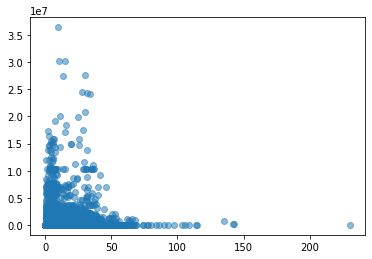

In [40]:
#loan_amount vs. loanspeed
fig, ax = plt.subplots()
ax.scatter(loan['loanspeed_days'],loan['ppp_val'], alpha=.5)
plt.show()


In [44]:
loan['ppp_val'].to_csv('ppp_val')

In [63]:
loan['ppp'].describe()

count    9036.000000
mean      463.346667
std      1235.094715
min         0.250961
25%         9.459933
50%        19.916697
75%       216.711076
max      8013.255859
Name: ppp, dtype: float64

Text(0.5, 1.0, 'Scatterplot of Average # of Days to Raise Loan by Loan Size, Sized by Number of Loans')

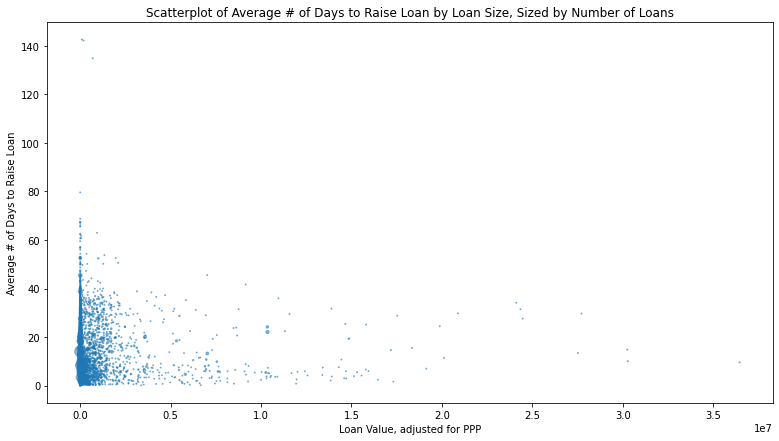

In [42]:
#Mean fulfillment speed of loan amounts, sized by n of loan amounts
loan_mean = loan.groupby(['ppp_val'])['loanspeed_days'].mean()
loan_count = loan.groupby(['ppp_val'])['ppp_val'].count()

#loan_count

#grouped.index
fig, ax = plt.subplots(figsize=(13,7))
ax.scatter(loan_mean.index, loan_mean, s=loan_count, alpha=.5)
ax.set_xlabel('Loan Value, adjusted for PPP')
ax.set_ylabel('Average # of Days to Raise Loan')
ax.set_title('Scatterplot of Average # of Days to Raise Loan by Loan Size, Sized by Number of Loans')


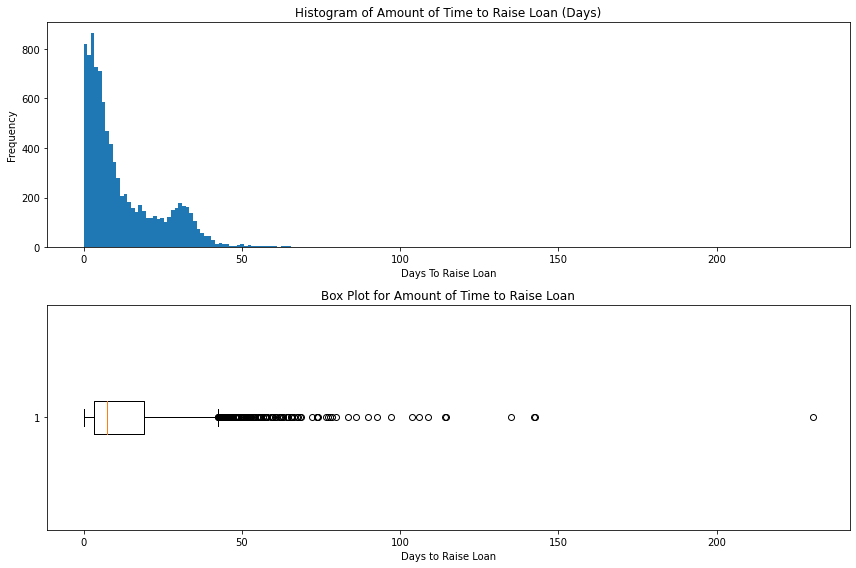

<Figure size 432x288 with 0 Axes>

In [122]:
fig, ax = plt.subplots(2,figsize=(12,8))
ax[0].hist(loan['loanspeed_days'], bins=200, label='histogram',)
ax[0].set_title('Histogram of Amount of Time to Raise Loan (Days)')
ax[0].set_xlabel('Days To Raise Loan')
ax[0].set_ylabel('Frequency')
ax[1].boxplot(loan['loanspeed_days'], vert=False)
ax[1].set_title('Box Plot for Amount of Time to Raise Loan')
ax[1].set_xlabel('Days to Raise Loan')
plt.tight_layout()
plt.show()
plt.savefig('../images/histobox.png')







In [124]:
stats.shapiro(loan['loanspeed_days'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8043903112411499, pvalue=0.0)